# eda023_derived_raw

In [12]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)
from math import * 
import scipy.optimize as opt
import multiprocessing
pd.set_option('display.max_columns', 50)

In [13]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [14]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [15]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [16]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [17]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [18]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [19]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [20]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [21]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = pd.read_csv(INPUT + '/prep/ground_truth_train.csv')
    return base_train, base_test, sample_sub, ground_truth

In [22]:
def ecef2lla(x, y, z):
    # x, y and z are scalars or vectors in meters
    x = np.array([x]).reshape(np.array([x]).shape[-1], 1)
    y = np.array([y]).reshape(np.array([y]).shape[-1], 1)
    z = np.array([z]).reshape(np.array([z]).shape[-1], 1)

    a=6378137
    a_sq=a**2
    e = 8.181919084261345e-2
    e_sq = 6.69437999014e-3

    f = 1/298.257223563
    b = a*(1-f)

    # calculations:
    r = np.sqrt(x**2 + y**2)
    ep_sq  = (a**2-b**2)/b**2
    ee = (a**2-b**2)
    f = (54*b**2)*(z**2)
    g = r**2 + (1 - e_sq)*(z**2) - e_sq*ee*2
    c = (e_sq**2)*f*r**2/(g**3)
    s = (1 + c + np.sqrt(c**2 + 2*c))**(1/3.)
    p = f/(3.*(g**2)*(s + (1./s) + 1)**2)
    q = np.sqrt(1 + 2*p*e_sq**2)
    r_0 = -(p*e_sq*r)/(1+q) + np.sqrt(0.5*(a**2)*(1+(1./q)) - p*(z**2)*(1-e_sq)/(q*(1+q)) - 0.5*p*(r**2))
    u = np.sqrt((r - e_sq*r_0)**2 + z**2)
    v = np.sqrt((r - e_sq*r_0)**2 + (1 - e_sq)*z**2)
    z_0 = (b**2)*z/(a*v)
    h = u*(1 - b**2/(a*v))
    phi = np.arctan((z + ep_sq*z_0)/r)
    lambd = np.arctan2(y, x)

    return phi*180/np.pi, lambd*180/np.pi, h

# baselineの再作成

In [23]:
def prepare_calc_baseline(df):
    light_speed = 299_792_458
    omega_e = 7.2921151467e-5
    
    # Corrected pseudorange according to data instructions
    df['correctedPrM'] = df['rawPrM'] + \
                         df['satClkBiasM'] - \
                         df['isrbM'] - \
                         df['ionoDelayM'] - \
                         df['tropoDelayM']
    
    # Time it took for signal to travel
    df['transmissionTimeSeconds'] = df['correctedPrM'] / light_speed
    
    # Compute true sat positions at arrival time
    df['xSatPosMRotated'] = \
        np.cos(omega_e * df['transmissionTimeSeconds']) * df['xSatPosM'] \
        + np.sin(omega_e * df['transmissionTimeSeconds']) * df['ySatPosM']

    df['ySatPosMRotated'] = \
        - np.sin(omega_e * df['transmissionTimeSeconds']) * df['xSatPosM'] \
        + np.cos(omega_e * df['transmissionTimeSeconds']) * df['ySatPosM']

    df['zSatPosMRotated'] = df['zSatPosM']
    
    # Uncertainty weight for the WLS method
    df['uncertaintyWeight'] = 1 / df['rawPrUncM']
    
    return df

In [24]:
def calc_baseline_point(df):

    def distance(sat_pos, x):
        sat_pos_diff = sat_pos.copy(deep=True)

        sat_pos_diff['xSatPosMRotated'] = sat_pos_diff['xSatPosMRotated'] - x[0]
        sat_pos_diff['ySatPosMRotated'] = sat_pos_diff['ySatPosMRotated'] - x[1]
        sat_pos_diff['zSatPosMRotated'] = sat_pos_diff['zSatPosMRotated'] - x[2]

        sat_pos_diff['d'] = sat_pos_diff['uncertaintyWeight'] * \
                            (np.sqrt((sat_pos_diff['xSatPosMRotated']**2 + sat_pos_diff['ySatPosMRotated']**2 + sat_pos_diff['zSatPosMRotated']**2)) + \
                             x[3] - sat_pos_diff['correctedPrM'])

        return sat_pos_diff['d']

    def distance_fixed_satpos(x):
        return distance(df[['xSatPosMRotated', 'ySatPosMRotated', 'zSatPosMRotated', 'correctedPrM', 'uncertaintyWeight']], x)
    
    x0 = [0,0,0,0]
    opt_res = opt.least_squares(distance_fixed_satpos, x0)
    # Optimiser yields a position in the ECEF coordinates
    opt_res_pos = opt_res.x
    
    # ECEF position to lat/long
    wls_estimated_pos = ecef2lla(*opt_res_pos[:3])
    wls_estimated_pos = np.squeeze(wls_estimated_pos)
    
    return wls_estimated_pos[0], wls_estimated_pos[1]

In [63]:
def get_derived_data(train_test, collection, phonename):
    derived = pd.read_csv(INPUT + f'/{train_test}/{collection}/{phonename}/{phonename}_derived.csv')
    raw = pd.read_csv(INPUT + f'/prep/gnss/{train_test}/{collection}/{phonename}/Raw.csv')
    status = pd.read_csv(INPUT + f'/prep/gnss/{train_test}/{collection}/{phonename}/Status.csv')
    
    delta_millis = derived['millisSinceGpsEpoch'] - derived['receivedSvTimeInGpsNanos'] / 1e6
    remove_signals = (delta_millis > 0) & (delta_millis < 300)
    derived = derived[~remove_signals].copy()
    
    # Assume we've loaded a dataframe from _GnssLog.txt for only lines beginning with "Raw", we denote this df_raw. Next, assume we've loaded a dataframe from _derived.csv. We denote this df_derived.

    # Create a new column in df_raw that corresponds to df_derived['MillisSinceGpsEpoch']
    raw['millisSinceGpsEpoch'] = np.floor( (raw['TimeNanos'] - raw['FullBiasNanos']) / 1000000.0).astype(int)
    
    # Change each value in df_derived['MillisSinceGpsEpoch'] to be the prior epoch.
    raw_timestamps = raw['millisSinceGpsEpoch'].unique()
    derived_timestamps = derived['millisSinceGpsEpoch'].unique()

    # The timestamps in derived are one epoch ahead. We need to map each epoch
    # in derived to the prior one (in Raw).
    indexes = np.searchsorted(raw_timestamps, derived_timestamps)
    from_t_to_fix_derived = dict(zip(derived_timestamps, raw_timestamps[indexes-1]))
    derived['millisSinceGpsEpoch'] = np.array(list(map(lambda v: from_t_to_fix_derived[v], derived['millisSinceGpsEpoch'])))

    # Compute signal_type in df_raw.
    # Map from constellation id to frequencies and signals.
    CONSTEL_FREQ_TABLE = {
        0: {'UNKNOWN': (0, 999999999999)},
        1: {
            'GPS_L1': (1563000000, 1587000000),
            'GPS_L2': (1215000000, 1240000000),
            'GPS_L5': (1164000000, 1189000000)
        },
        3: {
            'GLO_G1': (1593000000, 1610000000),
            'GLO_G2': (1237000000, 1254000000)
        },
        4: {
            'QZS_J1': (1563000000, 1587000000),
            'QZS_J2': (1215000000, 1240000000),
            'QZS_J5': (1164000000, 1189000000)
        },
        5: {
            'BDS_B1C': (1569000000, 1583000000),
            'BDS_B1I': (1553000000, 1568990000),
            'BDS_B2A': (1164000000, 1189000000),
            'BDS_B2B': (1189000000, 1225000000)
        },
        6: {
            'GAL_E1': (1559000000, 1591000000),
            'GAL_E5A': (1164000000, 1189000000),
            'GAL_E5B': (1189000000, 1218000000),
            'GAL_E6': (1258000000, 1300000000)
        },
        7: {
            'IRN_S': (2472000000, 2512000000),
            'IRN_L5': (1164000000, 1189000000)
        },
    }

    def SignalTypeFromConstellationAndFequency(constel, freq_hz):
        'Returns the signal type as a string for the given constellation and frequency.'
        freqs = CONSTEL_FREQ_TABLE.get(constel, {})
        for id_freq_range in freqs.items():
            rng = id_freq_range[1]
            if rng[0] <= freq_hz <= rng[1]:
                return id_freq_range[0]
        return 'UNKNOWN'

    signal_types = itertools.chain(*[c.keys() for c in CONSTEL_FREQ_TABLE.values()])
    sig_type_cat = pd.api.types.CategoricalDtype(categories=signal_types)
    raw['signalType'] = raw.apply(lambda r: SignalTypeFromConstellationAndFequency(r.ConstellationType, r.CarrierFrequencyHz), axis=1).astype(sig_type_cat)

    # Fix QZS Svids issue. 

    # The SVID of any QZS sat in derived may be changed. Since it may be a many to one relationship, we'll need to adjust the values in Raw.
    new_to_old = {1:(183, 193), 2:(184, 194, 196), 3:(187, 189, 197, 199), 4:(185, 195, 200)}
    # Maps original svid to new svid for only ConstellationType=4.
    old_to_new={}
    for new_svid, old_svids in new_to_old.items():
        for s in old_svids:
            old_to_new[s] = new_svid
    raw['svid'] = raw.apply(lambda r: old_to_new.get(r.Svid, r.Svid) if r.ConstellationType == 4 else r.Svid, axis=1)
    del raw['collectionName']
    del raw['phoneName']
    
    derived = derived.merge(raw, on=['millisSinceGpsEpoch', 'svid', 'signalType'], how='left')
    
    # status
    status['millisSinceGpsEpoch'] = status['UnixTimeMillis'] - 315964800000 + 18000
    status['svid'] = status.apply(lambda r: old_to_new.get(r.Svid, r.Svid) if r.ConstellationType == 4 else r.Svid, axis=1)
    status['signalType'] = status.apply(lambda r: SignalTypeFromConstellationAndFequency(r.ConstellationType, r.CarrierFrequencyHz), axis=1).astype(sig_type_cat)
    del status['collectionName']
    del status['phoneName']
    status = status.drop_duplicates(subset=['svid', 'signalType', 'millisSinceGpsEpoch'])
    
    sv_sig = derived[['svid', 'signalType']].drop_duplicates()
    output_df = pd.DataFrame()
    for svid, signal in zip(sv_sig['svid'], sv_sig['signalType']):
        derived_tmp = derived[(derived['svid']==svid)&(derived['signalType']==signal)].copy()
        status_tmp = status[(status['svid']==svid)&(status['signalType']==signal)].copy()
        del status_tmp['svid']
        del status_tmp['signalType']
        output_tmp = pd.merge_asof(derived_tmp, status_tmp, on='millisSinceGpsEpoch', direction='nearest')
        output_df = output_df.append(output_tmp)
    
    return output_df

In [79]:
derived = get_derived_data('train', '2021-04-28-US-MTV-1', 'Pixel5')

In [80]:
derived.isnull().sum()

collectionName                                   0
phoneName                                        0
millisSinceGpsEpoch                              0
constellationType                                0
svid                                             0
signalType                                       0
receivedSvTimeInGpsNanos                         0
xSatPosM                                         0
ySatPosM                                         0
zSatPosM                                         0
xSatVelMps                                       0
ySatVelMps                                       0
zSatVelMps                                       0
satClkBiasM                                      0
satClkDriftMps                                   0
rawPrM                                           0
rawPrUncM                                        0
isrbM                                            0
ionoDelayM                                       0
tropoDelayM                    

<AxesSubplot:>

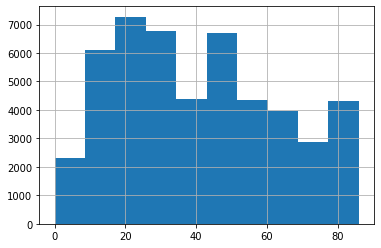

In [84]:
derived['ElevationDegrees'].hist()

In [69]:
derived.groupby(['UsedInFix', 'State'])['collectionName'].count()

UsedInFix  State
0          16399     5854
           23567    10773
           49359     1739
           81935     2187
1          16399    23305
           23567     2395
           49359     9365
           81935    12534
Name: collectionName, dtype: int64

In [70]:
derived.groupby(['UsedInFix', 'AccumulatedDeltaRangeState'])['collectionName'].count()

UsedInFix  AccumulatedDeltaRangeState
0          16                             9245
           17                              286
           19                              516
           21                              836
           25                             6531
           27                              977
           29                             2162
1          16                             8737
           17                             2350
           19                             1787
           21                             6545
           25                            21722
           27                             1808
           29                             4650
Name: collectionName, dtype: int64

In [71]:
derived.groupby(['UsedInFix'])['Cn0DbHz_x'].mean()

UsedInFix
0    29.819029
1    33.144024
Name: Cn0DbHz_x, dtype: float64

In [55]:
delta_millis = derived['millisSinceGpsEpoch'] - derived['receivedSvTimeInGpsNanos'] / 1e6
remove_signals = (delta_millis > 0) & (delta_millis < 300)
derived = derived[~remove_signals].copy()

In [48]:
tmp = derived[(derived['millisSinceGpsEpoch']==1303163466446)&(derived['svid']==15)&(derived['signalType']=='GAL_E1')]
tmp

,collectionName,phoneName,millisSinceGpsEpoch,constellationType,svid,signalType,receivedSvTimeInGpsNanos,xSatPosM,ySatPosM,zSatPosM,xSatVelMps,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM
68126,2021-04-22-US-SJC-1,Pixel4,1303163466446,6,15,GAL_E1,1303163465366308138,-2.165223e+07,-1.922732e+07,6115533.151,424.707,469.451,2983.745,245253.564,-0.001,2.398900e+07,2.698,-222.177,4.678,3.091
68152,2021-04-22-US-SJC-1,Pixel4,1303163466446,6,15,GAL_E1,1303163466366309287,-2.165181e+07,-1.922685e+07,6118516.852,424.994,469.583,2983.651,245253.564,-0.001,2.398865e+07,2.998,-224.545,4.678,3.091


In [49]:
tmp['millisSinceGpsEpoch'] - tmp['receivedSvTimeInGpsNanos'] / 1e6

68126    1079.691895
68152      79.690674
dtype: float64

In [15]:
def calc_baseline(args):
    s_th = 10
    
    phone, df = args
    collection = phone.split('_')[0]
    phonename = phone.split('_')[1]
    derived = get_derived_data('train', collection, phonename)
    derived = prepare_calc_baseline(derived)
    
    derived = derived[~(derived['MultipathIndicator']==1)].copy()
    derived = derived[~(derived['ElevationDegrees']<=20)].copy()
    derived = derived[~(derived['UsedInFix']==0)].copy()
    
    idx = list(df.index)
    s_list = []
    n_list = []
    lat_list = []
    lng_list = []
    unc_mean_list = []
    unc_max_list = []
    
    for j,i in enumerate(idx):
        s = df.at[i, 'millisSinceGpsEpoch']
        tmp = derived[(derived['millisSinceGpsEpoch']>=s-s_th)&(derived['millisSinceGpsEpoch']<=s+s_th)].copy()
        n = tmp['svid'].nunique()
        s_list.append(s)
        n_list.append(n)
        
        if n < 4:    
            lat_list.append(np.nan)
            lng_list.append(np.nan)
            unc_mean_list.append(np.nan)
            unc_max_list.append(np.nan)        
        
        else:
            res = calc_baseline_point(tmp)
            lat_list.append(res[0])
            lng_list.append(res[1])
            unc_mean_list.append(tmp['uncertaintyWeight'].mean())
            unc_max_list.append(tmp['uncertaintyWeight'].max())
    
    output_df = pd.DataFrame()
    output_df['millisSinceGpsEpoch'] = s_list
    output_df['latDeg'] = lat_list
    output_df['lngDeg'] = lng_list
    output_df['n'] = n_list
    output_df['unc_mean'] = unc_mean_list
    output_df['unc_max'] = unc_max_list
    output_df['collectionName'] = collection
    output_df['phoneName'] = phonename
    output_df['phone'] = phone
    
    return output_df

In [16]:
def calc_baseline_test(args):
    s_th = 10
    
    phone, df = args
    collection = phone.split('_')[0]
    phonename = phone.split('_')[1]
    derived = get_derived_data('test', collection, phonename)
    derived = prepare_calc_baseline(derived)
    
    derived = derived[~(derived['MultipathIndicator']==1)].copy()
    derived = derived[~(derived['ElevationDegrees']<=20)].copy()
    derived = derived[~(derived['UsedInFix']==0)].copy()
    
    idx = list(df.index)
    s_list = []
    n_list = []
    lat_list = []
    lng_list = []
    unc_mean_list = []
    unc_max_list = []
    
    for j,i in enumerate(idx):
        s = df.at[i, 'millisSinceGpsEpoch']
        tmp = derived[(derived['millisSinceGpsEpoch']>=s-s_th)&(derived['millisSinceGpsEpoch']<=s+s_th)].copy()
        n = tmp['svid'].nunique()
        s_list.append(s)
        n_list.append(n)
        
        if n < 4:    
            lat_list.append(np.nan)
            lng_list.append(np.nan)
            unc_mean_list.append(np.nan)
            unc_max_list.append(np.nan)        
        
        else:
            res = calc_baseline_point(tmp)
            lat_list.append(res[0])
            lng_list.append(res[1])
            unc_mean_list.append(tmp['uncertaintyWeight'].mean())
            unc_max_list.append(tmp['uncertaintyWeight'].max())
    
    output_df = pd.DataFrame()
    output_df['millisSinceGpsEpoch'] = s_list
    output_df['latDeg'] = lat_list
    output_df['lngDeg'] = lng_list
    output_df['n'] = n_list
    output_df['unc_mean'] = unc_mean_list
    output_df['unc_max'] = unc_max_list
    output_df['collectionName'] = collection
    output_df['phoneName'] = phonename
    output_df['phone'] = phone
    
    return output_df

In [17]:
df = get_derived_data('train', '2021-04-28-US-MTV-1', 'Pixel5')

In [18]:
df['UsedInFix'].value_counts(dropna=False)

1.0    29677
0.0    19414
NaN       10
Name: UsedInFix, dtype: int64

In [19]:
df = df[~(df['MultipathIndicator']==1)].copy()

In [20]:
df = df[~(df['ElevationDegrees']<=20)].copy()

In [21]:
df = df[~(df['UsedInFix']==0)].copy()

In [22]:
df

,collectionName,phoneName,millisSinceGpsEpoch,constellationType,svid,signalType,receivedSvTimeInGpsNanos,xSatPosM,ySatPosM,zSatPosM,xSatVelMps,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM,utcTimeMillis,TimeNanos,LeapSecond,TimeUncertaintyNanos,FullBiasNanos,...,CarrierPhaseUncertainty,MultipathIndicator,SnrInDb,ConstellationType_x,AgcDb,BasebandCn0DbHz_x,FullInterSignalBiasNanos,FullInterSignalBiasUncertaintyNanos,SatelliteInterSignalBiasNanos,SatelliteInterSignalBiasUncertaintyNanos,CodeType,ChipsetElapsedRealtimeNanos,UnixTimeMillis,SignalCount,SignalIndex,ConstellationType_y,Svid_y,CarrierFrequencyHz_y,Cn0DbHz_y,AzimuthDegrees,ElevationDegrees,UsedInFix,HasAlmanacData,HasEphemerisData,BasebandCn0DbHz_y
11,2021-04-28-US-MTV-1,Pixel5,1303683574429,6,13,GAL_E1,1303683574352084247,-7302972.174,-1.813378e+07,2.222515e+07,2066.035,849.250,1372.986,124615.524,0.000,2.333164e+07,9.294,-441.443,3.839,2.596,1619648356429,4259733502000000,18,NaN,-1299423840927910303,...,NaN,0,NaN,6,-60.0,23.1,-1471.951050,7.527566,NaN,NaN,C,21607552070750,1.619648e+12,31.0,18.0,6.0,13.0,1.575420e+09,27.9,29.0,72.0,1.0,1.0,1.0,23.099998
12,2021-04-28-US-MTV-1,Pixel5,1303683575429,6,13,GAL_E1,1303683575352083645,-7300906.042,-1.813293e+07,2.222652e+07,2066.232,849.130,1372.644,124615.524,0.000,2.333182e+07,8.094,-441.268,3.839,2.596,1619648357429,4259734502000000,18,NaN,-1299423840927910310,...,NaN,0,NaN,6,-60.0,24.6,-1471.925537,7.521198,NaN,NaN,C,21608552068453,1.619648e+12,31.0,18.0,6.0,13.0,1.575420e+09,29.4,29.0,72.0,1.0,1.0,1.0,24.599998
13,2021-04-28-US-MTV-1,Pixel5,1303683576429,6,13,GAL_E1,1303683576352083106,-7298839.712,-1.813208e+07,2.222790e+07,2066.429,849.011,1372.303,124615.524,0.000,2.333198e+07,6.296,-447.294,3.839,2.596,1619648358429,4259735502000000,18,NaN,-1299423840927910310,...,NaN,0,NaN,6,-60.0,26.5,-1471.868042,7.491431,NaN,NaN,C,21609552067147,1.619648e+12,31.0,18.0,6.0,13.0,1.575420e+09,31.3,29.0,72.0,1.0,1.0,1.0,26.500000
14,2021-04-28-US-MTV-1,Pixel5,1303683577429,6,13,GAL_E1,1303683577352082543,-7296773.185,-1.813123e+07,2.222927e+07,2066.626,848.892,1371.961,124615.524,0.000,2.333215e+07,7.195,-440.485,3.839,2.596,1619648359429,4259736502000000,18,NaN,-1299423840927910315,...,NaN,0,NaN,6,-60.0,25.5,-1472.095703,7.498764,NaN,NaN,C,21610552064537,1.619648e+12,31.0,18.0,6.0,13.0,1.575420e+09,30.3,29.0,72.0,1.0,1.0,1.0,25.500000
15,2021-04-28-US-MTV-1,Pixel5,1303683578429,6,13,GAL_E1,1303683578352081982,-7294706.461,-1.813038e+07,2.223064e+07,2066.823,848.773,1371.619,124615.524,0.000,2.333232e+07,7.195,-443.139,3.840,2.596,1619648360429,4259737502000000,18,NaN,-1299423840927910317,...,NaN,0,NaN,6,-60.0,25.2,-1472.350708,7.493708,NaN,NaN,C,21611552060836,1.619648e+12,31.0,18.0,6.0,13.0,1.575420e+09,30.0,29.0,72.0,1.0,1.0,1.0,25.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2021-04-28-US-MTV-1,Pixel5,1303685542429,3,12,GLO_G1,1303685542351374224,-6934603.893,9.136897e+06,2.280470e+07,-1722.163,-2597.136,519.213,67339.597,0.001,2.354450e+07,20.985,1126.562,8.250,13.307,1619650324429,4261701502000000,18,NaN,-1299423840927923172,...,NaN,0,NaN,3,-58.0,17.6,3805.417236,7.774380,NaN,NaN,C,23575545597739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2021-04-28-US-MTV-1,Pixel5,1303685543429,3,12,GLO_G1,1303685543351376751,-6936326.184,9.134300e+06,2.280522e+07,-1722.413,-2597.055,518.667,67339.598,0.001,2.354374e+07,11.992,1141.824,8.249,13.299,1619650325429,4261702502000000,18,NaN,-1299423840927923179,...,NaN,0,NaN,3,-58.0,21.9,3805.175049,7.771143,NaN,NaN,C,23576545592578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2021-04-28-US-MTV-1,Pixel5,1303685544429,3,12,GLO_G1,1303685544351379478,-6938048.727,9.131703e+06,2.280574e+07,-1722.662,-2596.974,518.121,67339.599,0.001,2.354292e+07,13.790,1140.580,8.

In [23]:
train, test, sub, gt = get_data()

In [24]:
target = ['2021-04-22-US-SJC-1_Pixel4', '2021-04-22-US-SJC-1_SamsungS20Ultra',
          '2021-04-28-US-SJC-1_Pixel4', '2021-04-28-US-SJC-1_SamsungS20Ultra',
          '2021-04-29-US-SJC-2_Pixel4', '2021-04-29-US-SJC-2_SamsungS20Ultra',
          '2021-04-28-US-MTV-1_Pixel4', '2021-04-28-US-MTV-1_Pixel5', '2021-04-28-US-MTV-1_SamsungS20Ultra',
          '2021-04-29-US-MTV-1_Pixel4', '2021-04-29-US-MTV-1_Pixel5', '2021-04-29-US-MTV-1_SamsungS20Ultra']
train = train[train['phone'].isin(target)].copy()

In [25]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(calc_baseline, train.groupby('phone'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
result = pd.concat(dfs)

0it [00:00, ?it/s]

In [26]:
train_tmp = train[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']].copy()
train_tmp.columns = ['phone', 'millisSinceGpsEpoch', 'latDeg_bl', 'lngDeg_bl']
result = result.merge(train_tmp, on=['phone', 'millisSinceGpsEpoch'], how='left')

In [27]:
gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']
gt_tmp = gt[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']].copy()
gt_tmp.columns = ['phone', 'millisSinceGpsEpoch', 'latDeg_gt', 'lngDeg_gt']
result = result.merge(gt_tmp, on=['phone', 'millisSinceGpsEpoch'], how='left')

In [28]:
result['rb_bl_err'] = calc_haversine(result['latDeg_bl'], result['lngDeg_bl'], result['latDeg'], result['lngDeg'])
result['rb_gt_err'] = calc_haversine(result['latDeg_gt'], result['lngDeg_gt'], result['latDeg'], result['lngDeg'])
result['bl_gt_err'] = calc_haversine(result['latDeg_gt'], result['lngDeg_gt'], result['latDeg_bl'], result['lngDeg_bl'])

In [29]:
for phone in result['phone'].unique():
    tmp = result[result['phone']==phone].copy()
    null_rate = tmp['latDeg'].isnull().sum() / len(tmp)
    print(phone, null_rate)

2021-04-29-US-MTV-1_Pixel5 0.0006265664160401002
2021-04-29-US-MTV-1_Pixel4 0.0006242197253433209
2021-04-29-US-MTV-1_SamsungS20Ultra 0.0006027727546714888
2021-04-28-US-MTV-1_Pixel5 0.0005037783375314861
2021-04-28-US-SJC-1_Pixel4 0.0019860973187686196
2021-04-28-US-MTV-1_SamsungS20Ultra 0.0005047955577990914
2021-04-28-US-SJC-1_SamsungS20Ultra 0.0009601536245799327
2021-04-28-US-MTV-1_Pixel4 0.0005002501250625312
2021-04-29-US-SJC-2_Pixel4 0.0017167381974248926
2021-04-29-US-SJC-2_SamsungS20Ultra 0.0008438818565400844
2021-04-22-US-SJC-1_SamsungS20Ultra 0.0014154281670205238
2021-04-22-US-SJC-1_Pixel4 0.001384083044982699


In [30]:
result_grouped = result.dropna().groupby('phone')[['rb_bl_err', 'rb_gt_err', 'bl_gt_err']].agg([percentile50, percentile95]).reset_index()
result_grouped.columns = ['phone', 'rb_bl_err_p50', 'rb_bl_err_p95', 'rb_gt_err_p50', 'rb_gt_err_p95', 'bl_gt_err_p50', 'bl_gt_err_p95']
result_grouped['rb_score'] = (result_grouped['rb_gt_err_p95'] + result_grouped['rb_gt_err_p50']) / 2
result_grouped['bl_score'] = (result_grouped['bl_gt_err_p95'] + result_grouped['bl_gt_err_p50']) / 2
result_grouped

,phone,rb_bl_err_p50,rb_bl_err_p95,rb_gt_err_p50,rb_gt_err_p95,bl_gt_err_p50,bl_gt_err_p95,rb_score,bl_score
0,2021-04-22-US-SJC-1_Pixel4,1.654703,20.932590,7.091520,41.889788,6.997472,42.133985,24.490654,24.565728
1,2021-04-22-US-SJC-1_SamsungS20Ultra,1.371024,14.856251,7.356437,28.519701,7.393606,28.045083,17.938069,17.719344
2,2021-04-28-US-MTV-1_Pixel4,1.075283,4.916206,2.046631,7.673834,2.164321,7.365087,4.860233,4.764704
3,2021-04-28-US-MTV-1_Pixel5,0.739491,2.875719,1.615985,4.587182,1.650982,3.956857,3.101583,2.803919
4,2021-04-28-US-MTV-1_SamsungS20Ultra,0.778870,3.565681,3.539691,11.542554,3.397275,11.083685,7.541123,7.240480
5,2021-04-28-US-SJC-1_Pixel4,2.213044,14.028654,4.796491,24.919666,4.167358,24.437963,14.858078,14.302661
6,2021-04-28-US-SJC-1_SamsungS20Ultra,1.709623,23.174068,5.911945,34.164893,5.727631,34.629760,20.038419,20.178696
7,2021-04-29-US-MTV-1_Pixel4,2.971406,13.828735,6.833109,19.786113,6.026172,16.005119,13.309611,11.015645
8,2021-04-29-US-MTV-1_Pixel5,4.361243,16.241658,7.758773,20.343813,6.595427,15.593213,14.051293,11.094320
9,2021-04-29-US-MTV-1_SamsungS20Ultra,0.809860,5.696548,6.475850,12.990243,6.344816,13.739767,9.733046,10.042291


In [31]:
result.to_csv(OUTPUT + '/result.csv', index=False)
result_grouped.to_csv(OUTPUT + '/result_grouped.csv', index=False)

In [32]:
result_grouped[['rb_score', 'bl_score']].mean()

rb_score    13.802164
bl_score    13.610966
dtype: float64

In [33]:
target = ['2021-04-22-US-SJC-1_Pixel4', '2021-04-22-US-SJC-1_SamsungS20Ultra',
          '2021-04-28-US-SJC-1_Pixel4', '2021-04-28-US-SJC-1_SamsungS20Ultra',
          '2021-04-29-US-SJC-2_Pixel4', '2021-04-29-US-SJC-2_SamsungS20Ultra']
result_grouped[result_grouped['phone'].isin(target)][['rb_score', 'bl_score']].mean()

rb_score    18.838180
bl_score    19.395039
dtype: float64

In [34]:
target = ['2021-04-28-US-MTV-1_Pixel4', '2021-04-28-US-MTV-1_Pixel5', '2021-04-28-US-MTV-1_SamsungS20Ultra',
          '2021-04-29-US-MTV-1_Pixel4', '2021-04-29-US-MTV-1_Pixel5', '2021-04-29-US-MTV-1_SamsungS20Ultra']
result_grouped[result_grouped['phone'].isin(target)][['rb_score', 'bl_score']].mean()

rb_score    8.766148
bl_score    7.826893
dtype: float64

In [35]:
result

,millisSinceGpsEpoch,latDeg,lngDeg,n,unc_mean,unc_max,collectionName,phoneName,phone,latDeg_bl,lngDeg_bl,latDeg_gt,lngDeg_gt,rb_bl_err,rb_gt_err,bl_gt_err
0,1303768902678,37.395835,-122.103000,7,0.242380,0.476417,2021-04-29-US-MTV-1,Pixel5,2021-04-29-US-MTV-1_Pixel5,37.395843,-122.103038,37.395825,-122.102925,3.461438,6.684964,10.140319
1,1303768903670,37.395754,-122.102841,6,0.292165,0.555864,2021-04-29-US-MTV-1,Pixel5,2021-04-29-US-MTV-1_Pixel5,37.395757,-122.102828,37.395825,-122.102925,1.137618,10.867007,11.430197
2,1303768904681,37.395859,-122.102940,7,0.275391,0.555864,2021-04-29-US-MTV-1,Pixel5,2021-04-29-US-MTV-1_Pixel5,37.395866,-122.102987,37.395825,-122.102925,4.205162,3.978334,7.092634
3,1303768905673,37.395834,-122.103073,7,0.292081,0.555864,2021-04-29-US-MTV-1,Pixel5,2021-04-29-US-MTV-1_Pixel5,37.395827,-122.102937,37.395825,-122.102925,12.075379,13.095244,1.027007
4,1303768906686,37.395842,-122.102998,7,0.288067,0.555864,2021-04-29-US-MTV-1,Pixel5,2021-04-29-US-MTV-1_Pixel5,37.395780,-122.102861,37.395825,-122.102925,13.909743,6.682114,7.573183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25330,1303163462446,37.334590,-121.899390,10,0.403392,0.834028,2021-04-22-US-SJC-1,Pixel4,2021-04-22-US-SJC-1_Pixel4,37.334590,-121.899411,37.334599,-121.899427,1.852724,3.464328,1.747994
25331,1303163463446,37.334587,-121.899387,10,0.403058,0.667111,2021-04-22-US-SJC-1,Pixel4,2021-04-22-US-SJC-1_Pixel4,37.334579,-121.899403,37.334599,-121.899427,1.676169,3.785345,3.040781
25332,1303163464446,37.334599,-121.899423,11,0.377574,0.667111,2021-04-22-US-SJC-1,Pixel4,2021-04-22-US-SJC-1_Pixel4,37.334589,-121.899423,37.334599,-121.899427,1.123740,0.387692,1.168164
25333,1303163465446,37.334622,-121.899391,11,0.412523,0.667111,2021-04-22-US-SJC-1,Pixel4,2021-04-22-US-SJC-1_Pixel4,37.334621,-121.899401,37.334599,-121.899427,0.864847,4.067802,3.407626


# test

In [36]:
target = ['2021-04-22-US-SJC-2_SamsungS20Ultra', '2021-04-29-US-SJC-3_Pixel4', '2021-04-29-US-SJC-3_SamsungS20Ultra']
test = test[test['phone'].isin(target)].copy()

In [37]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(calc_baseline_test, test.groupby('phone'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
result = pd.concat(dfs)

0it [00:00, ?it/s]

In [38]:
result.to_csv(OUTPUT + '/result_test.csv', index=False)

In [39]:
for phone in result['phone'].unique():
    tmp = result[result['phone']==phone].copy()
    null_rate = tmp['latDeg'].isnull().sum() / len(tmp)
    print(phone, null_rate)

2021-04-29-US-SJC-3_Pixel4 0.00202122283981809
2021-04-29-US-SJC-3_SamsungS20Ultra 0.00048520135856380397
2021-04-22-US-SJC-2_SamsungS20Ultra 0.0012908777969018934
